In [554]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt

import numpy as np

from qiskit_aer import AerSimulator
from qiskit import transpile

from qiskit_aer.noise import NoiseModel
from qiskit_aer.utils import insert_noise

import numpy as np
import sympy

## Problem Statement

We write a qiskit function that takes as inputs (1) a pair of booleans $x \in \mathbb{F}_2$ and (2) an error probability $p$ which characterizes the error rate for each qubit. The goal is to assess the performance of the 5-qubit [[5,1,3]] error correction code.

The notebook is structured as follows. First, in Section [I](#Encoding) we write a function that encodes an input boolean, $x_0$, into the corresponding 5-qubit logic state $\ket{0_L}$ or $\ket{1_L}$. In Section [II](#Stabilizers), we apply the necessary gates corresponding to the 4 stabilizers of the 5-qubit QECC to extract the eigenvalues of the stabilizers through classical measurements of 4 syndromes. In Section [III](#ErrorCorrection), we perform the necessary error correction operations based on the syndrome values that we obtained. In Section [IV](#Zbar), we perform a measurement of the logical $Z_L$ of the state returned by the QECC through an ancilla to avoid state collapse. This tells us whether the result is $|0_L\rangle$ or $|1_L\rangle$. 
In Section [V](#Deterministic), we test our Quantum Error Correcting Code (QECC) by applying a deterministic Pauli error on one qubit before feeding the state into the QECC. In Section [VI](#PauliChannel), we apply a Pauli string of errors on the physical qubits, and study the performance of the QECC as $p$ varies.

## Table of Contents

1. [Encoding $|0_L\rangle$ and $|1_L\rangle$](#Encoding)
2. [Adding gates for extracting stabilizer eigenvalues](#Stabilizers)
3. [Adding error correcting gates](#ErrorCorrection)
4. [Result of QECC code](#Zbar)
5. [Testing QECC (deterministic)](#Deterministic)
6. [Pauli error channel](#PauliChannel)

## Encoding $|0_L\rangle$ and $|1_L\rangle$ <a name = "Encoding"></a>

Pierce to add source.

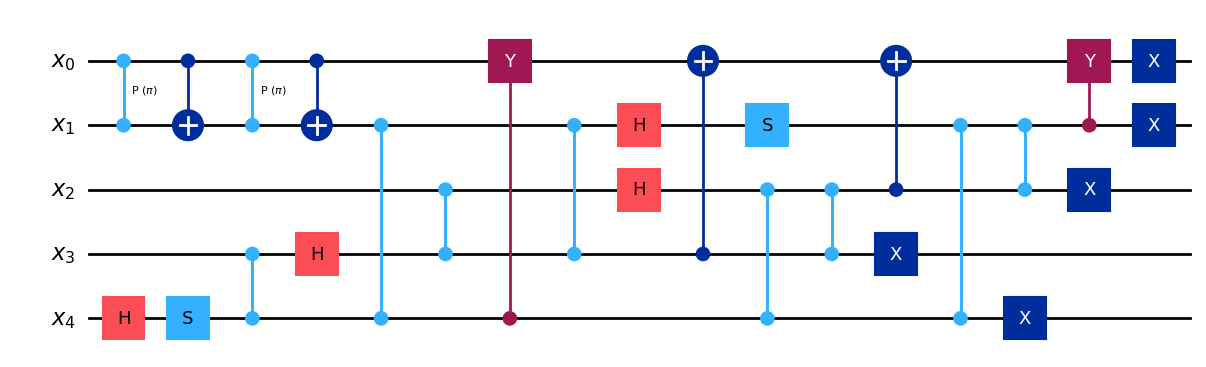

In [572]:
def encode(x0,qc,qr):
    # controlled phase flip - if the input state is |1>,
    # then flip the global phase by pi
    qc.cp(np.pi,qr[0],qr[1])
    qc.cx(qr[0],qr[1])
    qc.cp(np.pi,qr[0],qr[1])
    qc.cx(qr[0],qr[1])
    
    qc.h(qr[4])
    qc.s(qr[4])
    # g1
    qc.cz(qr[4],qr[3])
    qc.cz(qr[4],qr[1])
    qc.cy(qr[4],qr[0])
    
    qc.h(qr[3])
    #g2
    qc.cz(qr[3],qr[2])
    qc.cz(qr[3],qr[1])
    qc.cx(qr[3],qr[0])

    qc.h(qr[2])
    #g3
    qc.cz(qr[2],qr[4])
    qc.cz(qr[2],qr[3])
    qc.cx(qr[2],qr[0])

    qc.h(qr[1])
    qc.s(qr[1])
    #g4
    qc.cz(qr[1],qr[4])
    qc.cz(qr[1],qr[2])
    qc.cy(qr[1],qr[0])

    if x0==1:
        qc.x(qr)

def encodeGate(x0):
    qr_physical = QuantumRegister(5, name='x')
    qc= QuantumCircuit(qr_physical,name='here')
    encode(x0, qc, qr_physical)
    return qc.to_gate(label='5-qubit \nencode')


qr_physical = QuantumRegister(5, name='x')
qc= QuantumCircuit(qr_physical)
encode(1, qc, qr_physical)
qc.draw(output='mpl')


In [573]:
from IPython.display import display, Math
## Check encoding of logical states

from IPython.display import Latex
from qiskit.visualization import state_visualization

sv = Statevector(qc)
prefix = "$$\\begin{align} |1_L>= "
suffix = "\\end{align}$$"
state_to_latex = state_visualization._state_to_latex_ket(sv.data, max_size = 128)

qc= QuantumCircuit(qr_physical)
encode(0, qc, qr_physical)
sv = Statevector(qc)
prefix0 = "$$\\begin{align} |0_L>= "
suffix0 = "\\end{align}$$"
state0_to_latex = state_visualization._state_to_latex_ket(sv.data, max_size = 128)

Latex(prefix + state_to_latex + suffix)

<IPython.core.display.Latex object>

In [574]:
Latex(prefix0 + state0_to_latex + suffix0)

<IPython.core.display.Latex object>

It is easy to check that the above expressions agree with those found in Wikipedia.
Note that $|0_L\rangle$ has even parity (it has an even number of 1 in the physical basis decomposition) whereas $|1_L\rangle$ has odd parity (it has an odd number of 1 in the physical basis decomposition).

## Adding gates for extracting stabilizer eigenvalues <a name = "Stabilizers"></a>

We now start building the rest of the circuit. We first add the four neccessary syndromes.

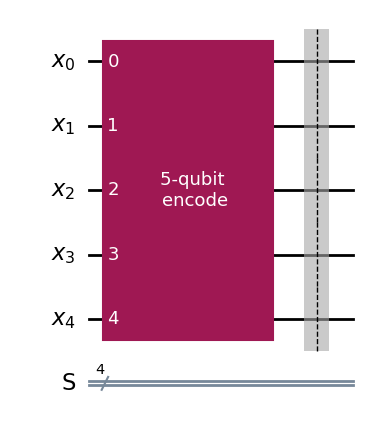

In [579]:
qr_physical = QuantumRegister(5, name='x')
qc= QuantumCircuit(qr_physical)
qc.compose(encodeGate(1),qr_physical, inplace=True)
qc.barrier()

syndrome = ClassicalRegister(4, name='S')
qc.add_register(syndrome)

#qc.y(qr_physical[4])

qc.draw(output='mpl')

Now we apply the stablizers using classical measurements on four ancillas. The stabilizers for the 5-qubit code are
\begin{align}
P_1 &= XZZXI \\
P_2 &= IXZZX \\
P_3 &= XIXZZ \\
P_4 &= ZXIXZ
\end{align}
where we do not explicitly write the $\otimes$ tensor product between the operators for notational easing.

Each stabilizer has an associated syndrome in the circuit that tests whether the eigenvalue of the stabilizer is 1 or -1. 

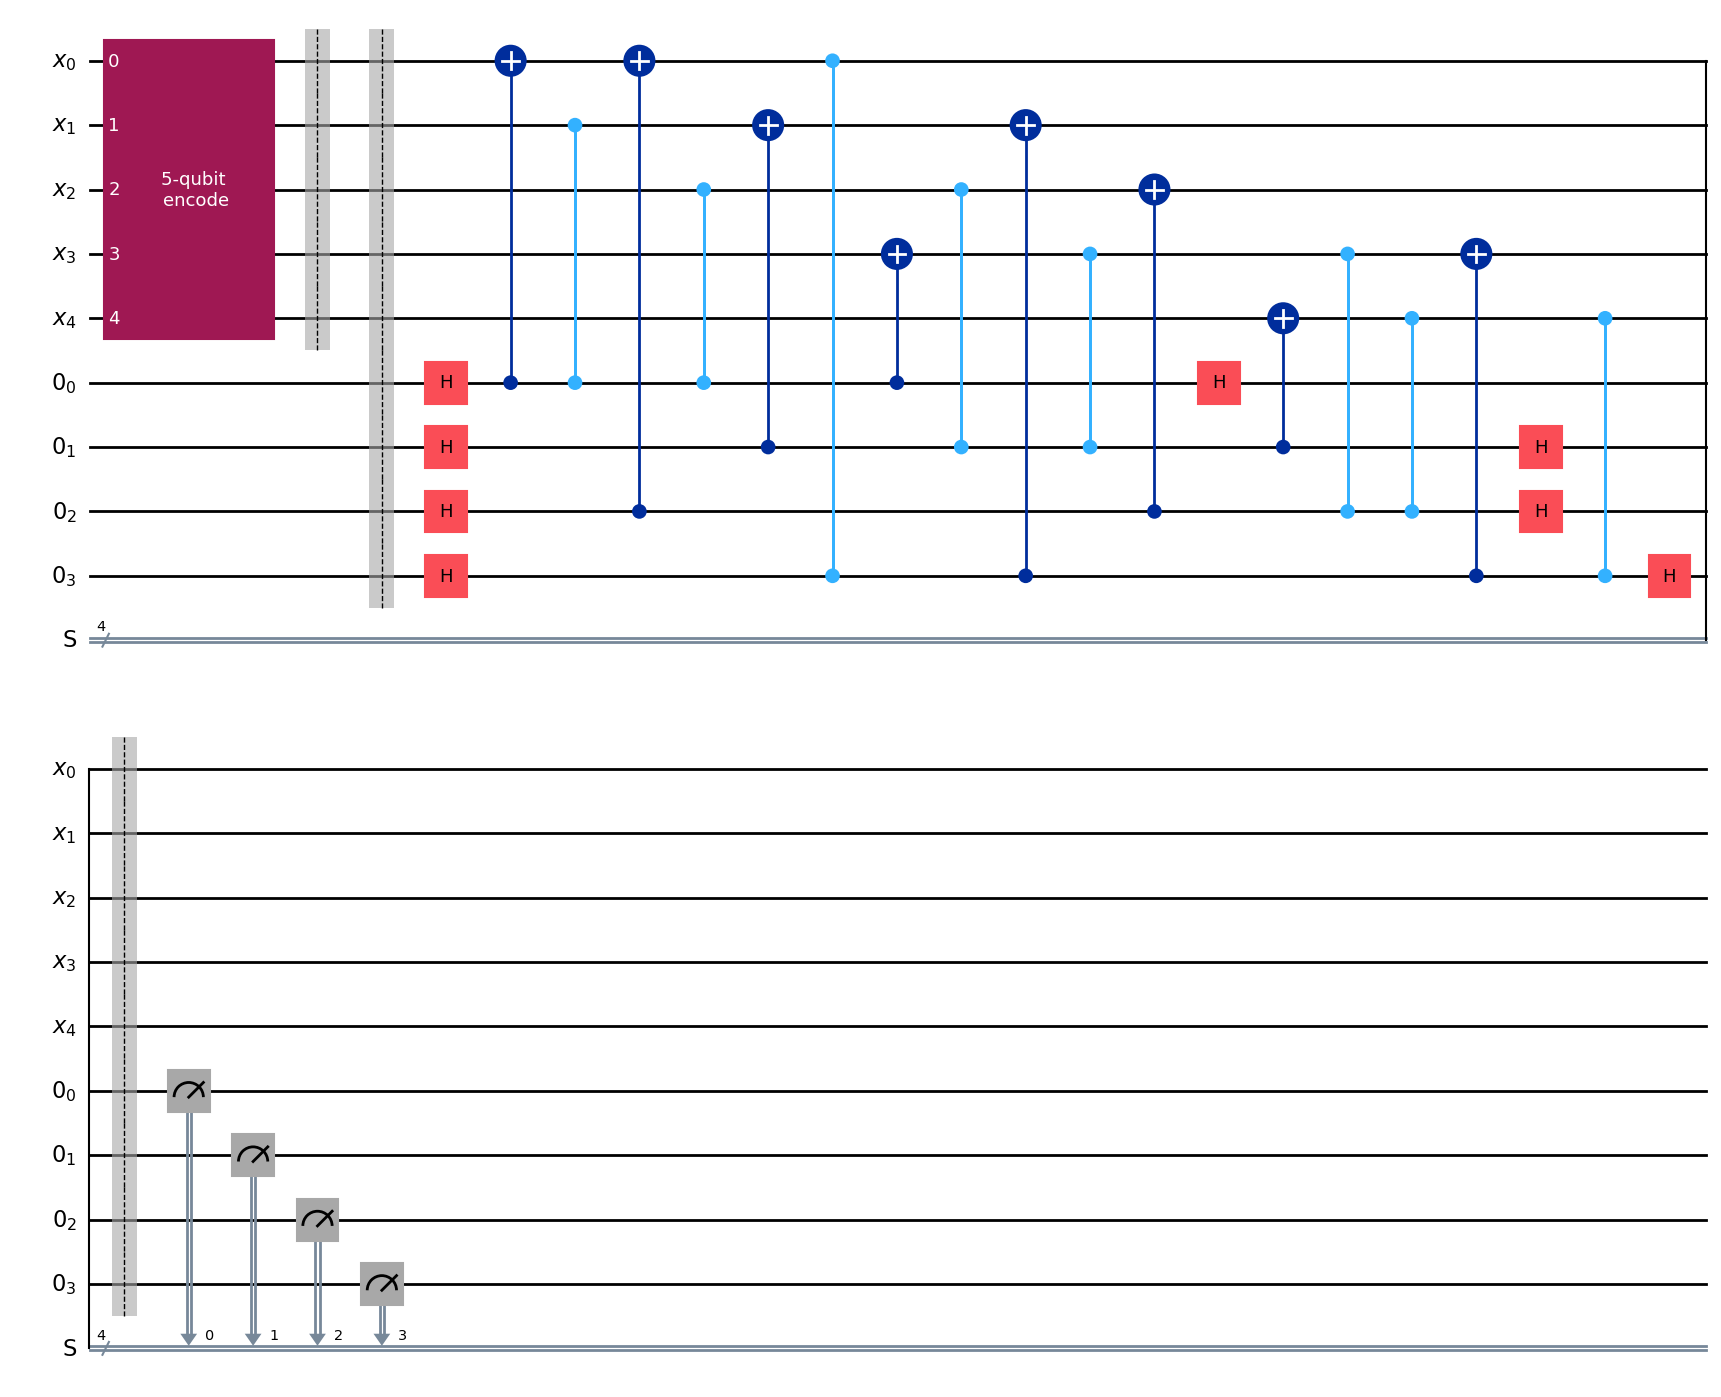

In [580]:
stabilizers = [
    'XZZXI',
    'IXZZX',
    'XIXZZ',
    'ZXIXZ'
]
def apply_stabilizers(qc, qr_physical,syndrome):
    anc = AncillaRegister(4, name='0')
    qc.add_register(anc)
    qc.barrier()
    qc.h(anc)
    for i, stab in enumerate(stabilizers):
        for j, bit in enumerate(stab):
            if bit == 'X':
                qc.cx(anc[i], qr_physical[j])
            elif bit == 'Z':
                qc.cz(anc[i], qr_physical[j])
        #qc.barrier()
    qc.h(anc)
    qc.barrier()
    for i in range(4):
        qc.measure(anc[i], syndrome[i])


apply_stabilizers(qc, qr_physical, syndrome)
qc.draw(output='mpl')

## Adding Error Correcting gates <a name = "ErrorCorrection"></a>

We now create a lookup table that dictates which gate to add based on which syndromes are activated. E.g. $P_4$ has a $Z$ in the first position and the other stabilizers have no $Z$ in the first position. So, if we have an $X$ error on the first qubit, that implies the syndromes should have the values (0,0,0,1) due to the non-commuting nature of $X$ and $Z$. The rest of the values can be constructed similarly. Basically, the only operators that can activate the values of the syndromes are those which do not commute with the stabilizers. 

Thus the values of the syndromes allow us to have a mapping to an error that occurred on a physical qubit. To correct the error, we apply the reverse of the gate after identifying the error. (since $X^2 = Y^2 = Z^2 = I$, they are their own inverses) 


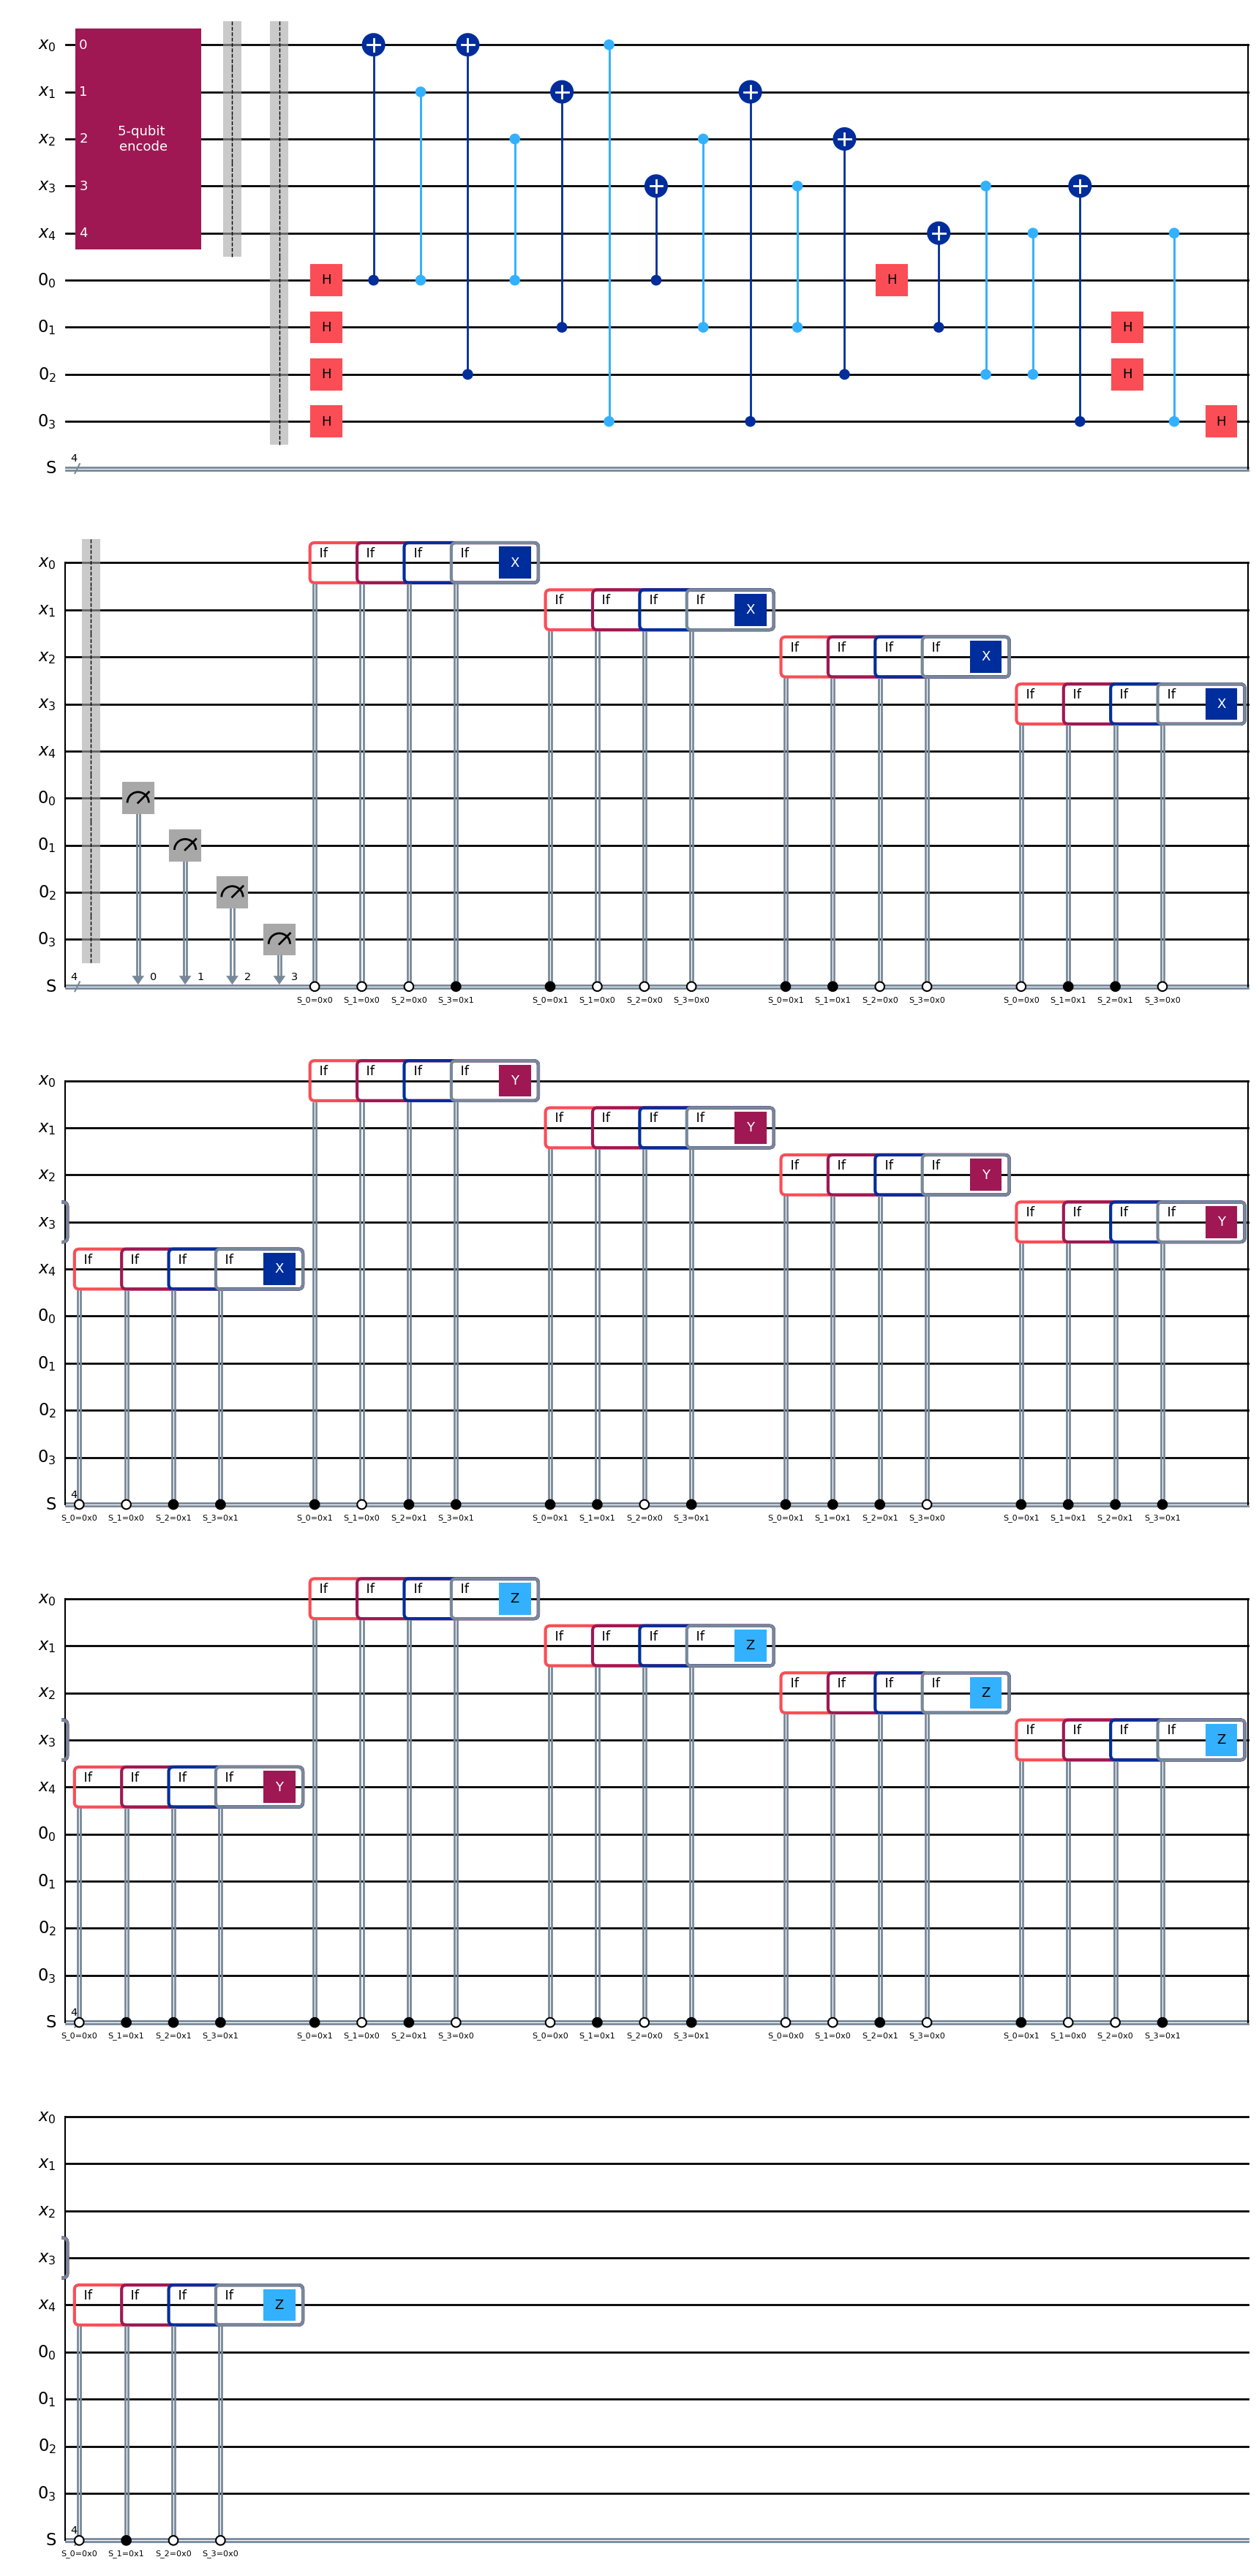

In [581]:
Lookup_Table = {
    'x1': [[0,0,0,1],'x',0],
    'x2': [[1,0,0,0],'x',1],
    'x3': [[1,1,0,0],'x',2],
    'x4': [[0,1,1,0],'x',3],
    'x5': [[0,0,1,1],'x',4],
    'y1': [[1,0,1,1],'y',0],
    'y2': [[1,1,0,1],'y',1],
    'y3': [[1,1,1,0],'y',2],
    'y4': [[1,1,1,1],'y',3],
    'y5': [[0,1,1,1],'y',4],
    'z1': [[1,0,1,0],'z',0],
    'z2': [[0,1,0,1],'z',1],
    'z3': [[0,0,1,0],'z',2],
    'z4': [[1,0,0,1],'z',3],
    'z5': [[0,1,0,0],'z',4],
    }
def CorrectErrors(qc, qr_physical, syndrome):
    for key in Lookup_Table:
        with qc.if_test((syndrome[0], Lookup_Table[key][0][0])):
            with qc.if_test((syndrome[1], Lookup_Table[key][0][1])):
                with qc.if_test((syndrome[2], Lookup_Table[key][0][2])):
                    with qc.if_test((syndrome[3], Lookup_Table[key][0][3])):
                        if Lookup_Table[key][1] == 'x':
                            qc.x(qr_physical[Lookup_Table[key][2]])
                        elif Lookup_Table[key][1] == 'y':
                            qc.y(qr_physical[Lookup_Table[key][2]])
                        elif Lookup_Table[key][1] == 'z':
                            qc.z(qr_physical[Lookup_Table[key][2]])
CorrectErrors(qc, qr_physical, syndrome)                            
qc.draw(output='mpl')


## Result of QECC code <a name = "Zbar"></a>

Finally, we construct the $\bar{Z} = ZZZZZ$ operator and measure the state of the system to be either $\ket{0_L}$ or $\ket{1_L}$. 
To avoid collapsing the state of the physical qubits, we add an ancilla qubit to do the measurement.

The ancilla starts in the $|0\rangle$ state. A Hadamard gate is applied to put the ancilla into the $|+\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$ state. The $CZ$ gate flips the phase of the ancilla if the target qubit is in $|1\rangle$ accumulating a phase of (-1) for each data qubit in $|1\rangle$. After all the $CZ$ gates, the ancilla encodes the parity of the five physical qubits. If an even number of them are in $|1\rangle$, the ancilla remains in $|+\rangle$. Otherwise it flips to $|-\rangle$. The final Hadamard gate acts as $H|+\rangle = |0\rangle$ or $H|-\rangle = |1\rangle$.

Therefore, if the measurement gives 0, the state is $|0_L\rangle$ (which has even parity) whereas if the measurement gives 1, the state is $|1_L\rangle$ (which has odd parity). 

Of course, in practice, one would also need to measure all the stabilizer eigenvalues to be 1 to make sure that we remain within the logical state space (after error correction), but we skip that step.

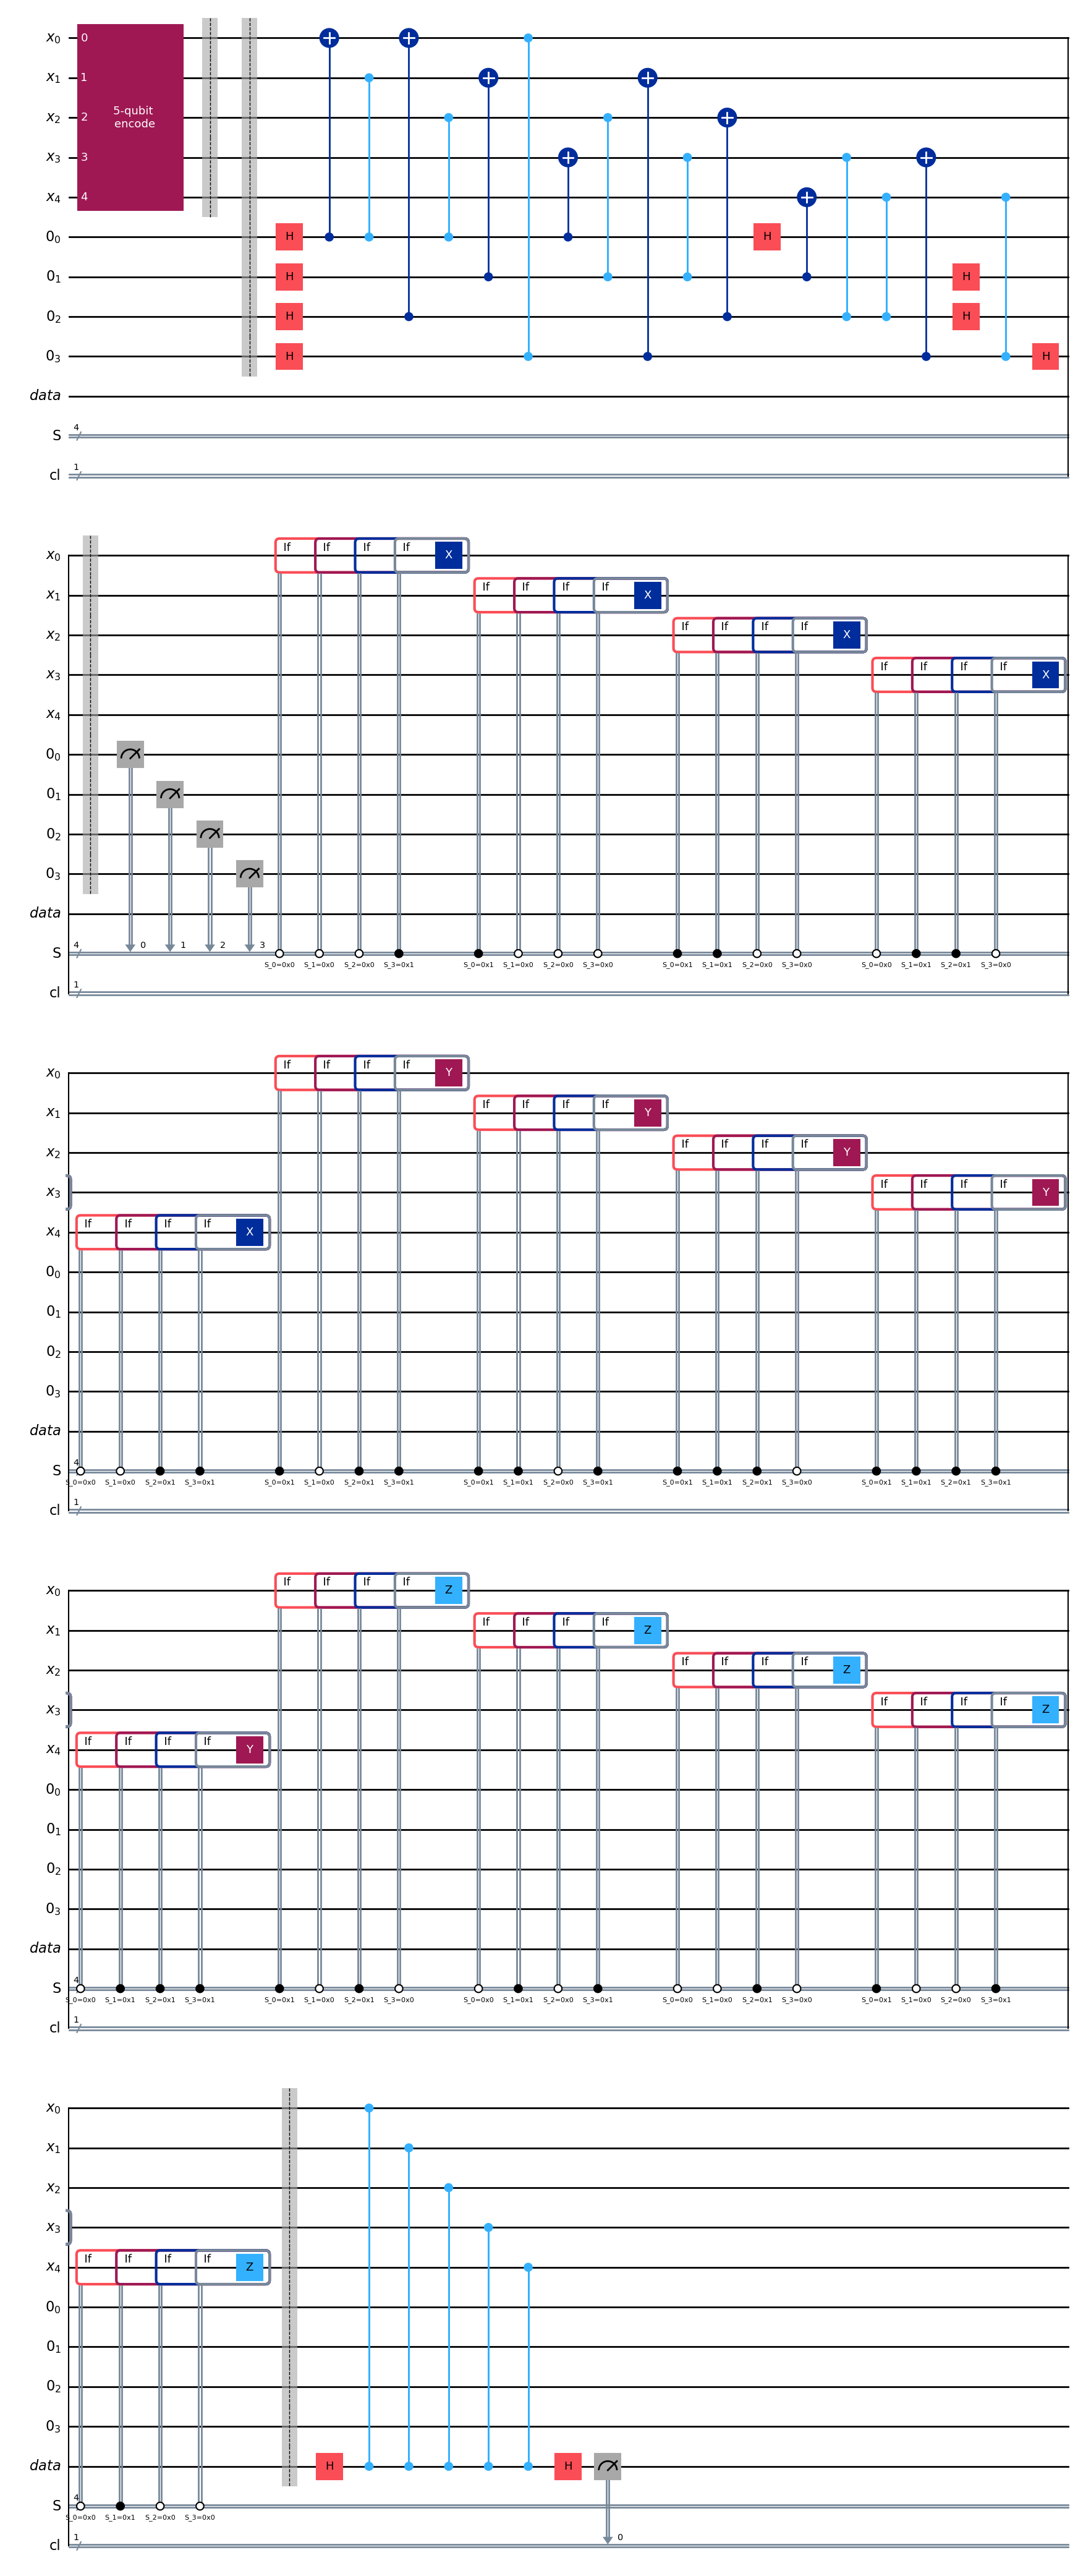

In [582]:
def MeasureData(qc, qr_physical):
    qr_data = QuantumRegister(1, name='data')
    qc.add_register(qr_data)
    qc.barrier()
    qc.h(qr_data)
    for i in range(5):
        qc.cz(qr_physical[i], qr_data)
    qc.h(qr_data)

    qr_cl = ClassicalRegister(1, name='cl')
    qc.add_register(qr_cl)
    qc.measure(qr_data, qr_cl)

MeasureData(qc, qr_physical)
qc.draw(output='mpl')

## Testing QECC (deterministic) <a name = "Deterministic"></a>

For simplicity, when testing we will only choose one qubit to apply a Pauli error on, since the QECC can only correct a maximum of $d = (3-1)/2 = 1$ error.
Now we put it all together and run a simulation to see if we did everything correctly.

In [583]:
#Input : error_gate is the Pauli error gate 'x', 'y' or 'z'.
#        error_qubit is the qubit number to apply Pauli error on.
def apply_error(qr_physical, error_gate, error_qubit):
    try:
        if error_gate == 'x':
            qc.x(qr_physical[error_qubit-1])
        elif error_gate == 'y':
            qc.y(qr_physical[error_qubit-1])
        elif error_gate == 'z':
            qc.z(qr_physical[error_qubit-1])
    except:
        raise Exception("error_qubit can only be 1,2,3,4,5 and error_gate can only be a Pauli gate.")
        
        
    

In [584]:
#Choose logical state being either 0 ( |0_L> ) or 1 ( |1_L> ) 
#Choose type of error : 'x', 'y' or 'z' to apply
#Choose qubit on which to apply error. It should be a number n such that 1 <= n <= 5.

logical_state = 1
error_gate = 'x' #must be a Pauli gate
error_qubit = 5

qr_physical = QuantumRegister(5, name='x')
qc= QuantumCircuit(qr_physical)

#Encoding of logical state
qc.compose(encodeGate(logical_state),qr_physical, inplace=True)
qc.barrier()

syndrome = ClassicalRegister(4, name='S')
qc.add_register(syndrome)

#Applying a known error here for testing
#qc.z(qr_physical[1]) 
apply_error(qr_physical, error_gate, error_qubit)

apply_stabilizers(qc, qr_physical, syndrome)
CorrectErrors(qc, qr_physical, syndrome) 
MeasureData(qc, qr_physical)

simulator = AerSimulator()
# Transpile the circuit for the backend
compiled_circuit = transpile(qc, simulator)

# Run the circuit
num_shots = 100
job = simulator.run(compiled_circuit, shots=num_shots)

# Get the measurement counts
counts = job.result().get_counts()
counts

#The first digit should be the same as the original input. The second set should tell which syndromes were activated and match the lookup table (order should be reversed though).


key_lookup = error_gate + str(error_qubit)
syndromes = Lookup_Table[key_lookup][0]
gate = Lookup_Table[key_lookup][1]
qubit_number = Lookup_Table[key_lookup][2] + 1

if len(counts) ==1:
    print("")
for key,value in counts.items():
    
    # checks that logical_state has been corrected in the expected way.
    if int(key[0]) == logical_state:
        print("After error correction, the logical state is", str(key[0]) +". This matches the input logical state.")
        print("A " + error_gate + " error gate was applied to qubit " + str(error_qubit))
        print("")

    
    ##double-check syndrome values with lookup table
    all_syndromes = True

    
    for i in range(len(syndromes)):
        if (syndromes[i] - int(key[5-i])) == 0:
            pass
        else:
            all_syndromes = False
            break
    if all_syndromes == False:
        raise Exception("At least one of the syndrome values in the lookup table does not match the error applied. This is not expected. Exit.")
            
            
    else:
        print("The error that was applied correctly maps to the syndrome values in the Lookup Table.")
        print("The syndrome values are", syndromes,".")
        print("")

     
    
    
    if value < num_shots:
        print("The QECC does not behave as expected.")
    else:
        print("The QECC behaves as expected. If the error is deterministic, all " + str(num_shots) + " measurements give the same syndrome values. Additionally, the error is always corrected to the closest logical state, which is in this case, the state (either |0_L> or |1_L>) that we feed into the QC. This is because the 5-qubit QECC can only correct one error, and we are only applying one error in this example.")

    
    


After error correction, the logical state is 1. This matches the input logical state.
A x error gate was applied to qubit 5

The error that was applied correctly maps to the syndrome values in the Lookup Table.
The syndrome values are [0, 0, 1, 1] .

The QECC behaves as expected. If the error is deterministic, all 100 measurements give the same syndrome values. Additionally, the error is always corrected to the closest logical state, which is in this case, the state (either |0_L> or |1_L>) that we feed into the QC. This is because the 5-qubit QECC can only correct one error, and we are only applying one error in this example.


In [585]:
counts

{'1 1100': 100}

## Pauli Error channel <a name = "PauliChannel"></a>

Let's add probabilistic error using Pauli gates. We will assume that for each qubit, an $X$, $Y$ or $Z$ error is applied with probability $p$. Thus for one qubit,
\begin{align}
P(\text{no error}) &= 1 - 3p \\
P(X \text{ error}) &= P(Y \text{ error}) = P(Z \text{ error}) = p
\end{align}
We will assume that an error is uncorrelated and of the form of a Pauli string, that is,
\begin{equation}
E = \sigma_{i_1} \otimes \sigma_{i_2} \otimes \ldots \sigma_{i_n}
\end{equation}
where $\sigma_{i_j} \in \{iI, X, Y, Z \}$ and where at least one of the $\sigma_{i_j}$ is a Pauli matrix.

Here we refrain from implementing the Pauli error using np.random since this prevents us from taking advantage of the `shots' parameter in the AER simulator. If we implemented our circuit this way, we would need make a new simulation for each sample.

Another way to implement the classically controlled Pauli operations from scratch would be to create a state $|\psi\rangle = p |0\rangle + p|1\rangle + p |2\rangle + (1-3p)|3\rangle$, using 2 qubits (this can be done using standard state preparation method with rotation multiplexers). Measure this state and store the result in a classical register. This would introduce the stochastic nature within the build of the circuit itself.

Below we opt instead for the noise_model provided by the AER simulator.

In [358]:
from qiskit_aer.noise import pauli_error

In [501]:
## another way of creating error?

def probabilistic_simulation(logical_state, p, num_shots):
    #Input : logical_state is either 0 or 1, 0< p<=1 is a float and denotes probability of applying a Pauli error on one qubit. 
    #        num_shots is the number of times to simulate the circuit using the aer simulator.

    
    error_qubit = pauli_error([("X", p), ("Y", p),("Z", p),("I", 1 - 3*p)])

    qr_physical = QuantumRegister(5, name='x')
    qc= QuantumCircuit(qr_physical)

    qc.append(encodeGate(logical_state),qr_physical) # Encode into |0_L> or |1_L>

    # Now I put id gates on the five qubits so that I can place Pauli_error on them later when using noise_model
    qc.id(0)
    qc.id(1)
    qc.id(2)
    qc.id(3)
    qc.id(4)
    qc.barrier()

    
    noise_model = NoiseModel()
    # Attach error on all gates which are id gates.
    noise_model.add_all_qubit_quantum_error(error_qubit, 'id')

    syndrome = ClassicalRegister(4, name='S')
    qc.add_register(syndrome)
    
    apply_stabilizers(qc, qr_physical, syndrome)
    CorrectErrors(qc, qr_physical, syndrome) 
    MeasureData(qc, qr_physical)
    
    
    simulator = AerSimulator(noise_model=noise_model)
    # Transpile the circuit for the backend
    compiled_circuit = transpile(qc, simulator,optimization_level=0, basis_gates = None)
    # Set optimization_level = 0 to not get rid of my id gates (because I set the Pauli error on those).
    # Set basis_gates = None to keep the original gates used in the circuit. Do not translate circuit to a set of particular gates since I do not specify backend.
    
    # Run the circuit
    #num_shots = 100
    job = simulator.run(compiled_circuit, shots=num_shots)
    
    # Get the measurement counts
    counts = job.result().get_counts()
    
    return counts


## Visualize the results
# Function
def success_failure(counts):
    successes = 0
    failures = 0
    for key,value in counts.items():
        if int(key[0])== logical_state:
            successes = successes + value
        else:
            failures = failures+value

    if (successes+failures) != sum(counts.values()):
        raise Exception("The total number of successes and failures is not equal to the total number of shots. Exit.")
    
    return successes,failures

##
def visualize(logical_state, num_shots):
    suc_arr = np.array([])
    fail_arr = np.array([])
    p_arr = np.arange(0,0.33+0.01,0.01)
    for p in p_arr:
        counts = probabilistic_simulation(logical_state, p, num_shots)
        successes,failures = success_failure(counts)
        suc_arr = np.append(suc_arr,successes)
        fail_arr = np.append(fail_arr, failures)

    return p_arr,suc_arr,fail_arr

    
        
    
    

    
    


In [527]:
logical_state = 0
num_shots = 1000
p_arr, suc_arr, fail_arr = visualize(logical_state,num_shots)
p_success_analytic = (1-3*p_arr)**5 + 5*3*p_arr*(1-3*p_arr)**4

Text(0, 0.5, 'Number of simulations')

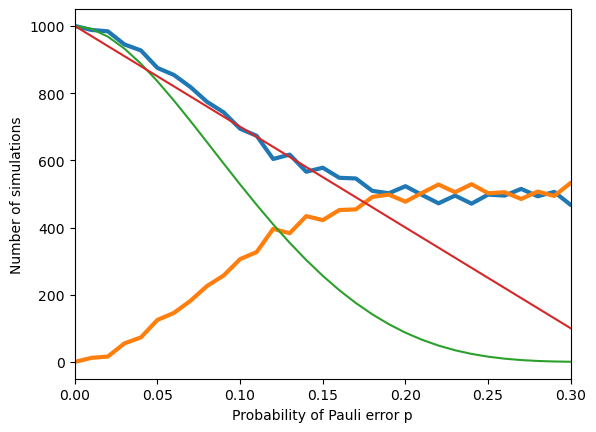

In [549]:
p_success_without_correction = (1-3*p_arr)
plt.plot(p_arr, suc_arr, linewidth=3)
plt.plot(p_arr, fail_arr, linewidth =3)
plt.plot(p_arr, p_success_analytic*num_shots)
plt.plot(p_arr, p_success_without_correction*num_shots)
#plt.yscale('log')
#plt.ylim(10**0,10**3)
plt.xlim(0,0.3)
plt.xlabel("Probability of Pauli error p")
plt.ylabel("Number of simulations")

As we can see from the above plot, our error correcting scheme only offers an advantage (over not having any error correction) when $p \lesssim 0.10$ (with some small variance on this value from the stochasticity). 

This is easily explained as follows. Let GS stand for 'guaranteed success' and S stand for 'success'.
\begin{align}
P(\text{GS}) &= P(0 \text{ error}) + P(1 \text{ error}) \\
&= (1-3p)^5 + 5(3p)(1-3p)^4 \quad \quad \text{(green line normalized to num\_shots)}
\end{align}
In principle, if more than one Pauli error occurs (that is, the weight of the Pauli string is > 1), we may still be correct if these errors still keep us closer to the logical state we started with (which is in this case $|0_L\rangle$ ) or if the ``error" happens to be one of the Pauli strings in the stabilizer subgroup. In fact, in the latter case, it is not even considered an error. This is because any stabilizer $P\in S$ keeps the logical state invariant : $P |\psi_L\rangle = |\psi_L\rangle$. Hence $P(S) \geq P(GS)$ holds since $P(S) = P(GS) + \text{corrections}$. The corrections are expected to get smaller with $p$ but we do not estimate the order. The corrections depend on the map $D : E/S \to \{|0_L\rangle, |1_L\rangle\}$ where $E$ is the set of errors and $S$ is the stabilizer (so basically which cosets with $W(E)>1$ still get mapped to $|0_L\rangle$). We do not study this further.

However, of course if we have undetectable errors (which also have zero syndromes but for example could transform $|0_L\rangle \to |1_L\rangle$), we would fail. Note that the code distance $d=3$ indicating that a minimum of 3 errors are enough to cause an undetectable error.

The red line gives the probability of success if we had no error correction scheme, and only used one physical qubit to encode one logical qubit i.e. $P_{\text{red}} = 1-3p$ (normalized to num_shots).

As can be seen from the plot, $P(GS)$ falls below $P_{\text{red}}$ when $p \sim 0.05$, indicating that the error correcting scheme (which gives $P(S)$ as the blue line) will fail around $p \gtrsim 0.05$ once the corrections are not enough to keep $P(S) \geq P_{\text{red}}$. This is exactly what we observe when $p \sim 0.10$.